<font size="6">Applied Data Science Project:</font>

<font size="4">Using Machine Learning To Detect Credit Card Fraud</font>

<font size="6">Importing Libraries</font>

In [3]:
#Example of supress warnings for Numpy version out of range (optional)
import warnings
warnings.filterwarnings("ignore", category=Warning)
warnings.simplefilter(action='ignore', category=FutureWarning)

#Some recommended libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import zipfile
import requests
from io import BytesIO
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

<font size="6">The Dataset</font>

In [4]:
df = pd.read_csv('CreditCardFraudDataScienceProject.csv')
df = df.drop('isFlaggedFraud', axis=1)
df.drop(columns=['nameOrig'], inplace=True)
df.drop(columns=['nameDest'], inplace=True)

print(df.head())

   step      type    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0     1   PAYMENT   9839.64       170136.0       160296.36             0.0   
1     1   PAYMENT   1864.28        21249.0        19384.72             0.0   
2     1  TRANSFER    181.00          181.0            0.00             0.0   
3     1  CASH_OUT    181.00          181.0            0.00         21182.0   
4     1   PAYMENT  11668.14        41554.0        29885.86             0.0   

   newbalanceDest  isFraud  
0             0.0        0  
1             0.0        0  
2             0.0        1  
3             0.0        1  
4             0.0        0  


In [5]:
df = df.sample(frac=0.01, random_state=42)

<font size="6">Data Preprocessing</font>

               step        amount  oldbalanceOrg  newbalanceOrig  \
count  63626.000000  6.362600e+04   6.362600e+04    6.362600e+04   
mean     243.566184  1.786235e+05   8.371806e+05    8.591415e+05   
std      142.874989  5.250773e+05   2.907155e+06    2.942573e+06   
min        1.000000  9.200000e-01   0.000000e+00    0.000000e+00   
25%      155.000000  1.358053e+04   0.000000e+00    0.000000e+00   
50%      239.000000  7.595040e+04   1.358400e+04    0.000000e+00   
75%      335.000000  2.095599e+05   1.065649e+05    1.464815e+05   
max      736.000000  3.697390e+07   3.359321e+07    3.388709e+07   

       oldbalanceDest  newbalanceDest       isFraud  
count    6.362600e+04    6.362600e+04  63626.000000  
mean     1.090121e+06    1.212517e+06      0.001367  
std      3.026498e+06    3.240527e+06      0.036953  
min      0.000000e+00    0.000000e+00      0.000000  
25%      0.000000e+00    0.000000e+00      0.000000  
50%      1.423221e+05    2.201724e+05      0.000000  
75%      

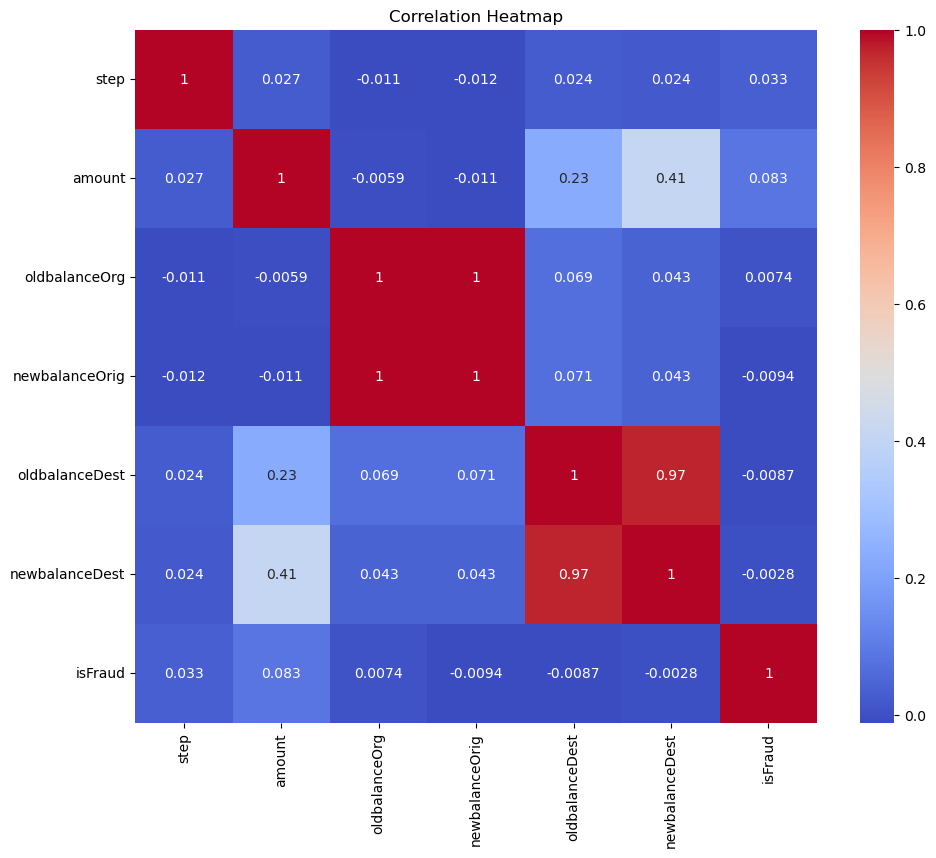

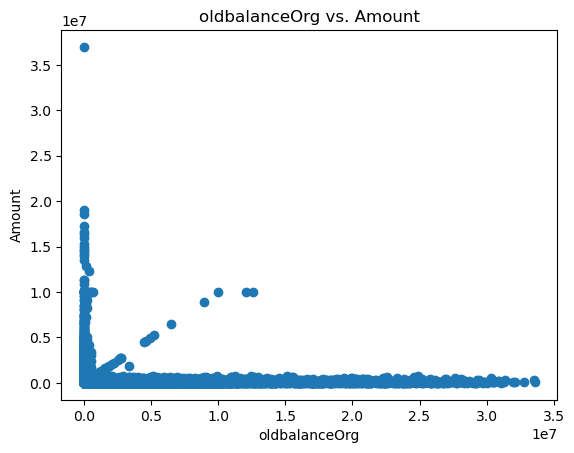

Type Counts are: type
CASH_OUT    22489
PAYMENT     21324
CASH_IN     14121
TRANSFER     5289
DEBIT         403
Name: count, dtype: int64
step               0
type               0
amount             0
oldbalanceOrg      0
newbalanceOrig     0
oldbalanceDest     0
newbalanceDest     0
isFraud            0
is_zero_balance    0
dtype: int64
             step    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
3737323  0.241009  0.288712      -0.280797       -0.172659       -0.210708   
264914  -1.599776 -0.318006      -0.277528       -0.285609       -0.360195   
85647   -1.634772 -0.050201      -0.251310       -0.204003       -0.293681   
5899326  1.115906  2.615135      -0.287975       -0.291972        0.696599   
2544263 -0.262933 -0.191309       0.716910        0.727384       -0.222800   

         newbalanceDest  isFraud  is_zero_balance  type_CASH_IN  \
3737323       -0.336465        0            False          True   
264914        -0.374176        0            False        

In [6]:


# VISUALIZATIONS SECTION
# gives basic statistical analysis for each feature
print(df.describe())
print(df.info())

count_fraud = df['isFraud'].value_counts()[1]  # Count where is_fraud is 1
count_non_fraud = df['isFraud'].value_counts()[0]  # Count where is_fraud is 0
print(f"Number of fraudulent transactions: {count_fraud}")
print(f"Number of non-fraudulent transactions: {count_non_fraud}")


# FEATURE ENGINEERING
# created a new feature that gives us if the balance of the account is 0 after the transaction.
df['is_zero_balance'] = df['newbalanceOrig'] == 0


# Calculate the correlation matrix & Heatmap
numeric_df = df.select_dtypes(include=[float, int])
corr_matrix = numeric_df.corr()

plt.figure(figsize=(11, 9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Scatter plot of oldbalanceorg and AmountS
plt.scatter(df['oldbalanceOrg'], df['amount'])
plt.title("oldbalanceOrg vs. Amount")
plt.xlabel("oldbalanceOrg")
plt.ylabel("Amount")
plt.show()

type_counts = df['type'].value_counts()
print(f"Type Counts are: {type_counts}")


# MISSING VALUES SECTION
missing_values = df.isnull().sum()
print(missing_values)

# ENCODING CATEGROICAL VARIABLES
df = pd.concat([df, pd.get_dummies(df['type'], prefix='type')], axis=1)
df.drop(columns=['type'], inplace=True)

# NORMALIZATION
numeric_columns = numeric_df.drop(columns=['isFraud'], errors='ignore').columns
scaler = StandardScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
print(df.head())

#TRAIN-TEST SPLIT
X = df.drop(columns=['isFraud']) 
y = df['isFraud']             

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Output the shapes of the resulting datasets
print(f"Training feature set shape: {X_train.shape}")
print(f"Test feature set shape: {X_test.shape}")
print(f"Training target set shape: {y_train.shape}")
print(f"Test target set shape: {y_test.shape}")


smote = SMOTE(sampling_strategy=0.25, random_state=42)  
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print(f"\nResampled Training feature set shape: {X_resampled.shape}")
print(f"Resampled Training target set shape: {y_resampled.shape}")



Accuracy: 0.9897
Classification Report with Default Threshold:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     12713
           1       0.07      0.77      0.13        13

    accuracy                           0.99     12726
   macro avg       0.54      0.88      0.56     12726
weighted avg       1.00      0.99      0.99     12726

Classification Report with Adjusted Threshold:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12713
           1       0.18      0.62      0.28        13

    accuracy                           1.00     12726
   macro avg       0.59      0.81      0.64     12726
weighted avg       1.00      1.00      1.00     12726



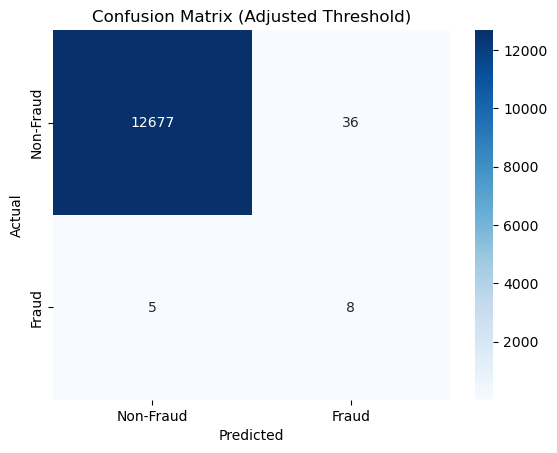

In [10]:
svm_model = SVC(C=10, gamma=1, kernel='rbf', random_state=42, class_weight='balanced', probability=True)
svm_model.fit(X_resampled, y_resampled)

# Predict on the test set
y_pred = svm_model.predict(X_test)


y_pred_prob = svm_model.predict_proba(X_test)[:, 1]
threshold = 0.5 
y_pred_adjusted = (y_pred_prob >= threshold).astype(int)

# Calculate accuracy with the default threshold
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print classification report with the default threshold
print("Classification Report with Default Threshold:")
print(classification_report(y_test, y_pred))

# Print classification report with the adjusted threshold
print("Classification Report with Adjusted Threshold:")
print(classification_report(y_test, y_pred_adjusted))

# Confusion Matrix with the adjusted threshold
cm = confusion_matrix(y_test, y_pred_adjusted)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title("Confusion Matrix (Adjusted Threshold)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Accuracy: 0.9987
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12713
           1       0.42      0.85      0.56        13

    accuracy                           1.00     12726
   macro avg       0.71      0.92      0.78     12726
weighted avg       1.00      1.00      1.00     12726



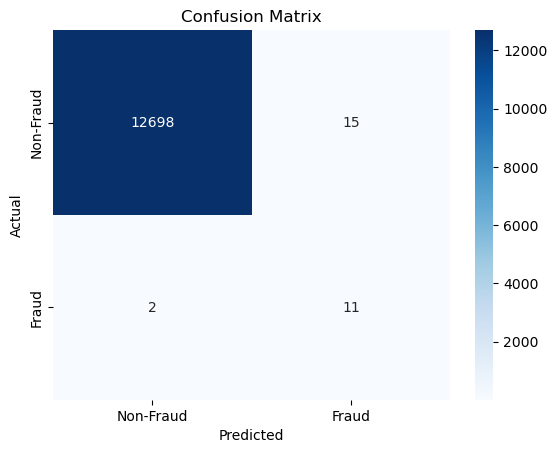

In [7]:
# Define the parameter grid
rf_model = RandomForestClassifier(
    class_weight='balanced',
    max_depth=20,
    min_samples_split=5,
    n_estimators=200,
    random_state=42
)

rf_model.fit(X_resampled, y_resampled)
# Predict on the test set
y_pred = rf_model.predict(X_test)

# Calculate the accuracy and display the classification report
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Classification Report for Voting Classifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     38120
           1       0.57      0.68      0.62        56

    accuracy                           1.00     38176
   macro avg       0.78      0.84      0.81     38176
weighted avg       1.00      1.00      1.00     38176



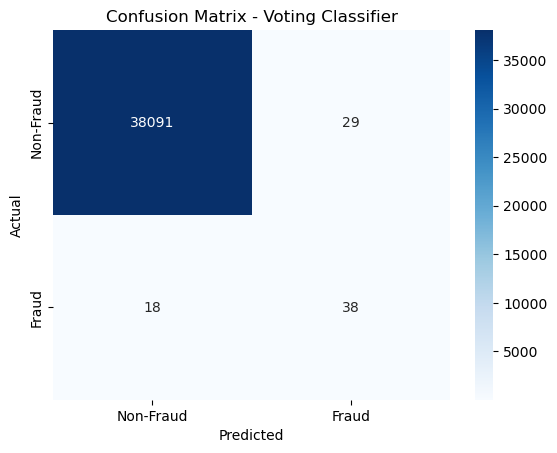

In [36]:
# Create a Voting Classifier using Hard Voting (Majority Voting)
voting_ensemble = VotingClassifier(
    estimators=[('svm', svm_model), ('rf', rf_model)],
    voting='hard'  
)

# Train the ensemble model using the resampled training data
voting_ensemble.fit(X_resampled, y_resampled)

# Predict on the test set
y_pred = voting_ensemble.predict(X_test)

# Print classification report
print("Classification Report for Voting Classifier:")
print(classification_report(y_test, y_pred))

# Optionally: Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title("Confusion Matrix - Voting Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


            Feature  Importance
2     oldbalanceOrg    0.287824
1            amount    0.136528
6   is_zero_balance    0.131516
11    type_TRANSFER    0.106152
0              step    0.079694
10     type_PAYMENT    0.056934
5    newbalanceDest    0.052690
3    newbalanceOrig    0.050494
4    oldbalanceDest    0.041694
8     type_CASH_OUT    0.028476
7      type_CASH_IN    0.027919
9        type_DEBIT    0.000079


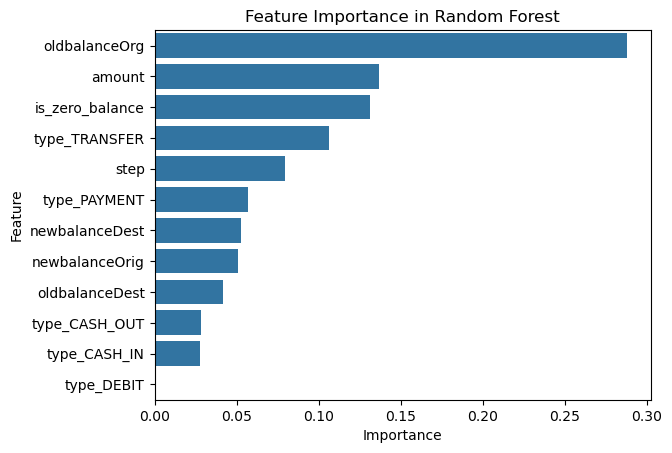

In [8]:
importances = rf_model.feature_importances_
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title("Feature Importance in Random Forest")
plt.show()